<a href="https://colab.research.google.com/github/UygarUsta/Codes/blob/main/Cars%20with%20SSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
get_ipython().system_raw("unrar x /content/drive/MyDrive/train_25class_marka.rar")

In [ ]:
from glob import glob

In [ ]:
path_ford = glob("/content/train_25class_marka/FORD/*.xml")
path_honda = glob("/content/train_25class_marka/HONDA/*.xml")
path = path_ford + path_honda


In [ ]:
from random import shuffle,seed
shuffle(path)

In [ ]:
import xml.etree.ElementTree as ET
from xml.dom.minidom import parse

for xmls in sorted(path):
    dom = parse(xmls)
    root = dom.documentElement
    split_path = "/".join(xmls.split("/")[:-1]) + "/"
    filename = root.getElementsByTagName("filename")[0].childNodes[0].data
    width = root.getElementsByTagName("width")[0].childNodes[0].data
    height = root.getElementsByTagName("height")[0].childNodes[0].data
    jpg = split_path+filename
    name = root.getElementsByTagName("name")[0].childNodes[0].data
    xmin = int(root.getElementsByTagName("xmin")[0].childNodes[0].data) 
    ymin = int(root.getElementsByTagName("ymin")[0].childNodes[0].data) 
    xmax = int(root.getElementsByTagName("xmax")[0].childNodes[0].data)  
    ymax = int(root.getElementsByTagName("ymax")[0].childNodes[0].data)  
    width = int(width)
    height = int(height)
    print((xmin/width)*224,(ymin/height)*224,(xmax/width)*224,(ymax/height)*224,jpg,width,height)
    break

6.122186495176849 28.47921760391198 176.10289389067526 134.7286063569682 /content/train_25class_marka/FORD/001348.jpg 622 409


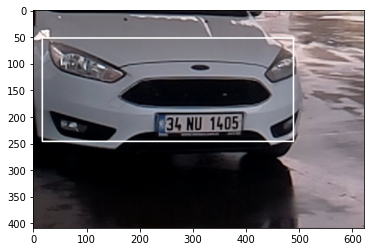

In [ ]:
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
img = cv2.imread("/content/train_25class_marka/FORD/001348.jpg")
cv2.rectangle(img,(17,52),(489,246),(255, 255, 255), 2)
plt.imshow(img[...,::-1])

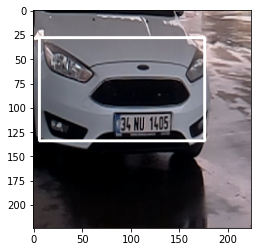

In [ ]:
img = cv2.imread("/content/train_25class_marka/FORD/001348.jpg")
img = cv2.resize(img,(224,224))
cv2.rectangle(img,(6,28),(176,134),(255, 255, 255), 2)
plt.imshow(img[...,::-1])

In [ ]:
!git clone https://github.com/pytorch/vision.git


Cloning into 'vision'...
remote: Enumerating objects: 31022, done.
remote: Counting objects: 100% (3565/3565), done.
remote: Compressing objects: 100% (823/823), done.
remote: Total 31022 (delta 2768), reused 3406 (delta 2673), pack-reused 27457
Receiving objects: 100% (31022/31022), 38.58 MiB | 31.51 MiB/s, done.
Resolving deltas: 100% (23378/23378), done.


In [ ]:
!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

In [ ]:
!pip install albumentations==0.4.6

     |████████████████████████████████| 122kB 8.2MB/s 
     |████████████████████████████████| 952kB 13.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-cp37-none-any.whl size=65175 sha256=25f04ddb8af58a82cbe0dc0b18563c106be18972c0fe966558bc184f2b342fb2
  Stored in directory: /root/.cache/pip/wheels/c7/f4/89/56d1bee5c421c36c1a951eeb4adcc32fbb82f5344c086efa14
Successfully built albumentations
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV

# matplotlib for visualization
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [ ]:
clx = [_,"FORD","HONDA"]
clx.index("FORD")

1

In [ ]:
class Cars(torch.utils.data.Dataset):
  def __init__(self,path,transforms = None):
    self.path = path
    self.transforms = transforms
    self.classes = [_,"FORD","HONDA"]
  def __len__(self):
    return len(self.path)
  def __getitem__(self,ix):
    img_name = self.path[ix].replace(".xml",".jpg")
    xml_name = self.path[ix]
    img = cv2.imread(img_name)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
    img_res = cv2.resize(img_rgb, (224, 224), cv2.INTER_AREA)
    img_res /= 255.0
    boxes = []
    labels = []

    wt = img.shape[1]
    ht = img.shape[0]

    dom = parse(xml_name)
    root = dom.documentElement
    filename = root.getElementsByTagName("filename")[0].childNodes[0].data
    name = root.getElementsByTagName("name")[0].childNodes[0].data
    labels.append(self.classes.index(name))
    xmin = int(root.getElementsByTagName("xmin")[0].childNodes[0].data) 
    ymin = int(root.getElementsByTagName("ymin")[0].childNodes[0].data) 
    xmax = int(root.getElementsByTagName("xmax")[0].childNodes[0].data)  
    ymax = int(root.getElementsByTagName("ymax")[0].childNodes[0].data) 

    xmin_corr = (xmin/wt)*224
    xmax_corr = (xmax/wt)*224
    ymin_corr = (ymin/ht)*224
    ymax_corr = (ymax/ht)*224
    boxes.append([xmin_corr,ymin_corr,xmax_corr,ymax_corr])
    boxes = torch.as_tensor(boxes,dtype = torch.float32)
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

    iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    target["area"] = area
    target["iscrowd"] = iscrowd
    image_id = torch.tensor([ix])
    target["image_id"] = image_id

    if self.transforms:


      sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            
      img_res = sample['image']
      target['boxes'] = torch.Tensor(sample['bboxes'])

    return img_res,target


In [ ]:
len(path)
train = path[:1350]
val = path[1350:]

In [ ]:
dataset = Cars(train)
im,target = dataset[14]

In [ ]:
target

{'area': tensor([21572.6562]),
 'boxes': tensor([[  2.1875,  34.7159, 214.3750, 136.3838]]),
 'image_id': tensor([14]),
 'iscrowd': tensor([0]),
 'labels': tensor([2])}

In [ ]:
def get_object_detection_model(num_classes):


  model = torchvision.models.detection.ssd300_vgg16(pretrained=True) 
    

  return model

In [ ]:
def get_transform(train):

    
  if train:
    return A.Compose([
                            A.HorizontalFlip(0.5),
                            A.RandomBrightnessContrast(p=0.2),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
  else:
    return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

In [ ]:
train_dataset = Cars(train,transforms=get_transform(train = True))
val_dataset = Cars(val,transforms = get_transform(train = False))

train_dl = torch.utils.data.DataLoader(
    train_dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

val_dl = torch.utils.data.DataLoader(
    val_dataset, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 3
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
model

SSD(
  (backbone): SSDFeatureExtractorVGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, train_dl, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, val_dl, device=device)

Epoch: [0]  [  0/135]  eta: 0:03:09  lr: 0.000042  loss: 3.8607 (3.8607)  bbox_regression: 0.8465 (0.8465)  classification: 3.0141 (3.0141)  time: 1.4058  data: 0.9217  max mem: 2679
Epoch: [0]  [ 10/135]  eta: 0:00:59  lr: 0.000415  loss: 3.2849 (3.3823)  bbox_regression: 0.9497 (0.9161)  classification: 2.3442 (2.4661)  time: 0.4730  data: 0.1008  max mem: 2679
Epoch: [0]  [ 20/135]  eta: 0:00:49  lr: 0.000788  loss: 2.9485 (2.9792)  bbox_regression: 0.7799 (0.8153)  classification: 2.1011 (2.1639)  time: 0.3838  data: 0.0230  max mem: 2679
Epoch: [0]  [ 30/135]  eta: 0:00:44  lr: 0.001161  loss: 2.2227 (2.6761)  bbox_regression: 0.5893 (0.7328)  classification: 1.6629 (1.9433)  time: 0.3901  data: 0.0273  max mem: 2679
Epoch: [0]  [ 40/135]  eta: 0:00:39  lr: 0.001533  loss: 2.0563 (2.5101)  bbox_regression: 0.5419 (0.6863)  classification: 1.5051 (1.8238)  time: 0.3933  data: 0.0270  max mem: 2679
Epoch: [0]  [ 50/135]  eta: 0:00:34  lr: 0.001906  loss: 2.0214 (2.4293)  bbox_regres

In [ ]:
im,target = val_dataset[34]

In [ ]:
def torch_to_pil(img):

  return torchtrans.ToPILImage()(img).convert('RGB')


In [ ]:
model.eval()

with torch.no_grad():
  prediction = model([im.to(device)])[0]

print("Predicted #boxes:",len(prediction["labels"]))
print("Real #boxes:",len(target["labels"]))


Predicted #boxes: 1
Real #boxes: 1


In [ ]:
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
  fig, a = plt.subplots(1,1)
  fig.set_size_inches(5,5)
  a.imshow(img)
  for box in (target):
    x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
    rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 1,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
    a.add_patch(rect)
  plt.show()

Without NMS


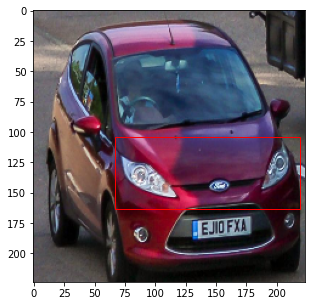

In [ ]:
print("Without NMS")
plot_img_bbox(torch_to_pil(im),prediction["boxes"])

In [ ]:
def nms(prediction,iou_thresh):
  best_box = len(prediction["scores"][prediction["scores"] > iou_thresh].cpu().numpy().tolist())
  bbox = prediction["boxes"][:best_box]
  best_score = prediction["scores"][:best_box]
  best_labels = prediction["labels"][:best_box]
  return bbox,best_score,best_labels

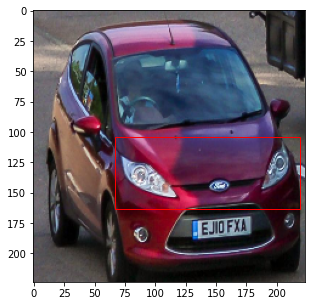

tensor([1], device='cuda:0')


In [ ]:
apply_nms = nms(prediction,0.186) #return bbox 
plot_img_bbox(torch_to_pil(im),apply_nms[0])
#print("Predicted is:",val_dataset.classes[nms(prediction,0.9)[2].cpu().numpy()[0]])
print(apply_nms[2])

In [ ]:
!wget https://i0.shbdn.com/photos/20/64/04/x5_936206404pvd.jpg

--2021-07-15 20:24:12--  https://i0.shbdn.com/photos/20/64/04/x5_936206404pvd.jpg
Resolving i0.shbdn.com (i0.shbdn.com)... 31.3.2.88
Connecting to i0.shbdn.com (i0.shbdn.com)|31.3.2.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258052 (252K) [image/jpeg]
Saving to: ‘x5_936206404pvd.jpg.1’

x5_936206404pvd.jpg 100%[===================>] 252.00K   553KB/s    in 0.5s    

2021-07-15 20:24:14 (553 KB/s) - ‘x5_936206404pvd.jpg.1’ saved [258052/258052]



In [ ]:
from time import time
def predict(path,iou):

  img = cv2.imread(path)
  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
  img_res = cv2.resize(img_rgb, (224, 224), cv2.INTER_AREA)
  img_res /= 255.0
  img_res = torch.tensor(img_res).permute(2,0,1).float().to(device)
  model.eval()

  with torch.no_grad():
    s = time()
    prediction = model([img_res])[0]
    x = time()
  


  apply_nms = nms(prediction,iou) 
  nms_box = apply_nms[0]
  nms_score = apply_nms[1].cpu().numpy()
  nms_label = apply_nms[2].cpu().numpy()
  plot_img_bbox(img_res.cpu().permute(1,2,0).numpy(),nms_box)
  print("\nfps",1 / (x - s))
  print("label:{},score:{}".format(nms_label,nms_score))
  

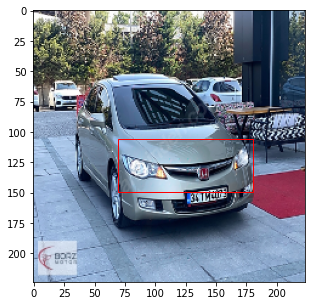


fps 20.68268628601579
label:[2],score:[0.99885726]
Index 1:FORD,Index 2:HONDA


In [ ]:
predict("/content/x5_936206404pvd.jpg",0.185)
print("Index 1:{},Index 2:{}".format(clx[1],clx[2]))

In [ ]:
!wget https://i0.shbdn.com/photos/10/62/92/x5_938106292pd9.jpg

--2021-07-15 20:25:23--  https://i0.shbdn.com/photos/10/62/92/x5_938106292pd9.jpg
Resolving i0.shbdn.com (i0.shbdn.com)... 85.153.138.181
Connecting to i0.shbdn.com (i0.shbdn.com)|85.153.138.181|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67104 (66K) [image/jpeg]
Saving to: ‘x5_938106292pd9.jpg’

x5_938106292pd9.jpg 100%[===================>]  65.53K   174KB/s    in 0.4s    

2021-07-15 20:25:24 (174 KB/s) - ‘x5_938106292pd9.jpg’ saved [67104/67104]



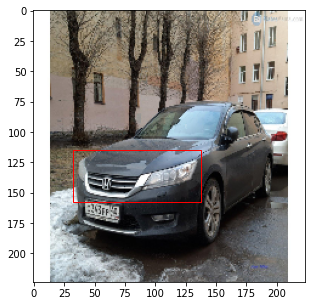


fps 20.732167130478626
label:[2],score:[0.99884534]


In [ ]:
predict("/content/train_25class_marka/HONDA/Honda_Accord_164.jpg",0.185)